In [1]:
from pathlib import Path

import random
import numpy as np
import cv2
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset,Subset
from sklearn.model_selection import KFold

import utilities
import BiseNet

In [2]:
# Before everything starting, please create a workspace folder named RUGD_ws 
# Move folders RUGD_frames-with-annotations and RUGD_annotations into RUGD_ws
# Create folder model within RUGD_ws
# Set workspace path here
workspace_path="/root/autodl-tmp/RUGD_ws"

frames_folder_name="RUGD_frames-with-annotations"
annotations_folder_name="RUGD_annotations"
annotations_index_folder_name="RUGD_annotations_index"
model_folder_name="model"

random_state=42
random.seed(random_state)

In [6]:
# Index labels generation
annotations_path=Path(workspace_path)/annotations_folder_name
annotation_index_path=Path(workspace_path)/annotations_index_folder_name
annotation_index_path.mkdir()
print("Start generating index labels.")
dirs_list=utilities.get_dirs_list(annotations_path)
for p in dirs_list:
    new_p=Path(annotation_index_path/p.name)
    new_p.mkdir()
    files_list=utilities.get_files_list(p,".png")
    for f in tqdm(files_list,desc=f"folder '{p.name}' is being processed.",total=len(files_list)):
        cv2.imwrite((new_p/f.name).as_posix(),utilities.convert_color2index(f.as_posix()))
print("Generating index labels finishes.")

Start generating index labels


folder 'park-2' is being processed.: 100%|██████████| 656/656 [04:56<00:00,  2.21it/s]

Generating index labels finishes


Start spliting dataset into training and testing.


Calculate distribution: 100%|██████████| 7436/7436 [00:26<00:00, 280.87it/s]


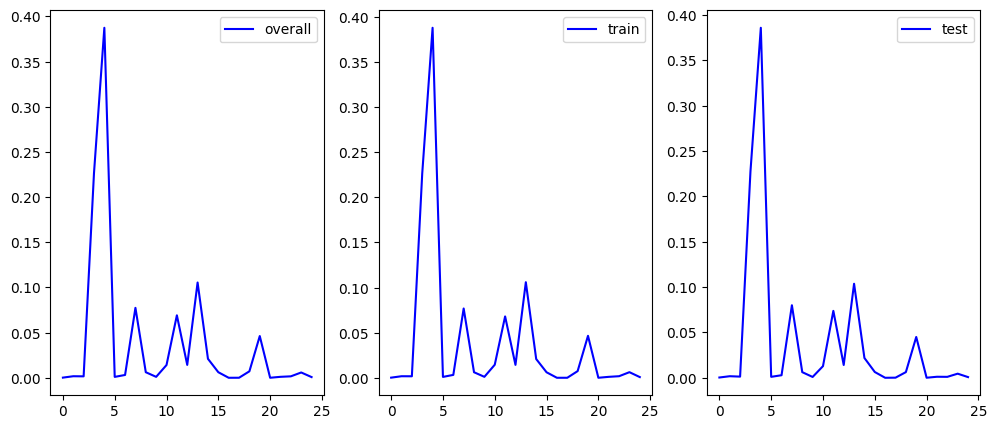

Finish.


In [7]:
# Dataset spliting
# Set test data ratio here
test_size=0.2
# Set the number of classes here
num_classes=25

frames_path=Path(workspace_path)/frames_folder_name
annotations_index_path=Path(workspace_path)/annotations_index_folder_name
saving_path=Path(workspace_path)

print("Start spliting dataset into training and testing.")
X_path_list=[]
y_path_list=[]
y=[]
dirs_list=utilities.get_dirs_list(frames_path)
for p in tqdm(dirs_list,desc="Load frames: ",total=len(dirs_list)):
    files_list=utilities.get_files_list(p,".png")
    for f in files_list:
        frame_path=f
        label_path=annotations_index_path/frame_path.parent.name/frame_path.name
        X_path_list.append(frame_path)
        y_path_list.append(label_path)
        y.append(cv2.imread(label_path.as_posix(),cv2.IMREAD_UNCHANGED))

y=np.array(y)
N = y.shape[0]
pixel_distribution = np.zeros((N, num_classes), dtype=np.float32)
for i in tqdm(range(N),desc=f"Calculate distribution",total=N):
    unique, counts = np.unique(y[i], return_counts=True)
    total_pixels = y[i].size
    for u, count in zip(unique, counts):
        pixel_distribution[i, u] = count / total_pixels

overall_distribution = np.mean(pixel_distribution, axis=0)

train_indices=[]
test_indices=[]
for i, dist in enumerate(pixel_distribution):
    if random.random() > test_size:
        train_indices.append(i)
    else:
        test_indices.append(i)

train_pixel_distribution = np.mean(pixel_distribution[train_indices], axis=0)
test_pixel_distribution = np.mean(pixel_distribution[test_indices], axis=0)

x=np.arange(0,num_classes,1)
plt.figure(figsize=(12, 5))
plt.subplot(1,3,1)
plt.plot(x, overall_distribution, color='blue', label='overall')
plt.legend(loc='best')
plt.subplot(1,3,2)
plt.plot(x, train_pixel_distribution, color='blue', label='train')
plt.legend(loc='best')
plt.subplot(1,3,3)
plt.plot(x, test_pixel_distribution, color='blue', label='test')
plt.legend(loc='best')
plt.show()

train_data_path_str_list=[]
for index in train_indices:
    index_frame_path=Path("")/X_path_list[index].parent.parent.name/X_path_list[index].parent.name/X_path_list[index].name
    index_label_path=Path("")/y_path_list[index].parent.parent.name/y_path_list[index].parent.name/y_path_list[index].name
    train_data_path_str_list.append([index_frame_path.as_posix(),index_label_path.as_posix()])
np.savetxt((saving_path/"train_data_path.csv").as_posix(),np.array(train_data_path_str_list),delimiter=',',fmt='%s')

test_data_path_str_list=[]
for index in test_indices:
    index_frame_path=Path("")/X_path_list[index].parent.parent.name/X_path_list[index].parent.name/X_path_list[index].name
    index_label_path=Path("")/y_path_list[index].parent.parent.name/y_path_list[index].parent.name/y_path_list[index].name
    test_data_path_str_list.append([index_frame_path.as_posix(),index_label_path.as_posix()])
np.savetxt((saving_path/"test_data_path.csv").as_posix(),np.array(test_data_path_str_list),delimiter=',',fmt='%s')
print("Finish.")

In [10]:
# Standardization_para_calculating
class TrainingDataset(Dataset):
    def __init__(self,workspace_path,training_data_csv_file_name) -> None:
        workspace_path=Path(workspace_path)
        csv_file_path=workspace_path/training_data_csv_file_name
        files_list= np.genfromtxt(csv_file_path.as_posix(),dtype=None,encoding='utf-8',delimiter=',')
        self.frame_path_list=[]
        for s in files_list[:,:1].tolist():
            self.frame_path_list.append(workspace_path/s[0])

    def __len__(self) -> int:
        return len(self.frame_path_list)
    
    def __getitem__(self, index):
        image=cv2.imread(self.frame_path_list[index].as_posix(),cv2.IMREAD_UNCHANGED)
        image=transforms.ToTensor()(image)
        return image

csv_file_name="train_data_path.csv"
dataset=TrainingDataset(workspace_path,csv_file_name)
data_loader=DataLoader(dataset=dataset,batch_size=32)

sum_bgr=torch.zeros(3,dtype=torch.float64)
num_pixel=0
for images in tqdm(data_loader,desc="Calculate mean: "):
    sum_bgr+=torch.sum(images,[0,2,3])
    num_pixel+=images.size(0)*images.size(2)*images.size(3)
mean=(sum_bgr/num_pixel)
print(f"mean: {mean}")

sum_squared_bgr=torch.zeros(3,dtype=torch.float64)
for images in tqdm(data_loader,desc="Calculate std: "):
    resharped_mean=mean[None, :, None, None]
    difference_value=images-resharped_mean
    squared_difference_value=difference_value**2
    sum_squared_bgr+=squared_difference_value.sum([0,2,3])
std=torch.sqrt(sum_squared_bgr/num_pixel)
print(f"std: {std}")

Calculate mean: 100%|██████████| 186/186 [01:22<00:00,  2.26it/s]


mean: tensor([0.4015, 0.4037, 0.4037], dtype=torch.float64)


Calculate std: 100%|██████████| 186/186 [01:50<00:00,  1.68it/s]

std: tensor([0.2780, 0.2756, 0.2738], dtype=torch.float64)


In [5]:
class CustomDataset(Dataset):
    def __init__(self, workspace_path:str, csv_file_name:str, color_transforms:transforms, target_size=None|tuple, loading_mode="pre"):
        workspace_path=Path(workspace_path)
        csv_file_path=workspace_path/csv_file_name
        files_list=np.genfromtxt(csv_file_path,dtype=None,encoding='utf-8',delimiter=',')
        self.num_files=files_list.shape[0]
        self.color_transforms=color_transforms
        self.target_size=target_size
        self.loading_mode=loading_mode

        self.data_file_full_path_list=[]
        for pair in files_list:
            color_file_path=workspace_path/pair[0]
            index_file_path=workspace_path/pair[1]
            self.data_file_full_path_list.append([color_file_path,index_file_path])

        self.color_index_list=None
        if loading_mode=="pre":
            with ThreadPoolExecutor() as executor:
                self.color_index_list=list(tqdm(executor.map(self.__load_color_and_index__,self.data_file_full_path_list),desc="Load images and labels",total=self.__len__()))

    def __load_color_and_index__(self,path_pair)->list:
        color_image_path=path_pair[0]
        index_label_path=path_pair[1]
        color_image=cv2.imread(color_image_path.as_posix(),cv2.IMREAD_UNCHANGED)
        index_label=cv2.imread(index_label_path.as_posix(),cv2.IMREAD_UNCHANGED)
        if self.target_size is not None:
            color_image=cv2.resize(color_image,self.target_size,interpolation=cv2.INTER_LINEAR)
            index_label=cv2.resize(index_label,self.target_size,interpolation=cv2.INTER_NEAREST)
        return[color_image,index_label]

    def __len__(self)->int:
        return self.num_files

    def __getitem__(self, index):
        color_image=None
        index_label=None
        if self.loading_mode=="pre":
            color_image=self.color_index_list[index][0]
            index_label=self.color_index_list[index][1]
        else:
            pair=self.__load_color_and_index__(self.data_file_full_path_list[index])
            color_image=pair[0]
            index_label=pair[1]
        color_image=self.color_transforms(color_image)
        index_label=torch.from_numpy(index_label).long() 
        return color_image,index_label

In [6]:
# Parameters of training
color_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4015, 0.4037, 0.4037],std=[0.2780, 0.2756, 0.2738])
])
loading_mode="pre"
num_classes=25
target_size=(512,512)
num_folds=5
epochs=100
batch_size=16
learning_rate=0.001

In [11]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current used device is {device}")

Current used device is cuda


In [ ]:
# Training
training_dataset=CustomDataset(workspace_path,"train_data_path.csv",color_transforms,target_size,loading_mode)

y_training_loss=np.zeros((num_folds,epochs),dtype=np.float32)
y_val_loss=np.zeros((num_folds,epochs),dtype=np.float32)
y_val_pixel_wise_accuracy=np.zeros((num_folds,epochs),dtype=np.float32)
y_val_mIoU=np.zeros((num_folds,epochs),dtype=np.float32)
kf=KFold(n_splits=num_folds,shuffle=True,random_state=random_state)
for fold,(training_idx,val_idx) in enumerate(kf.split(training_dataset)):
    training_subset=Subset(training_dataset,training_idx)
    val_subset=Subset(training_dataset,val_idx)

    training_loader=DataLoader(training_subset,batch_size,shuffle=True,drop_last=True)
    val_loader=DataLoader(val_subset,batch_size,shuffle=True,drop_last=True)
    torch.cuda.empty_cache()
    model=BiseNet.BiSeNet(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        message=f"Current fold: {fold+1}/{num_folds} Current epoch:{epoch+1}/{epochs} "
        model.train()
        batch_training_loss_sum = 0.0
        for images, labels in tqdm(training_loader, desc=message+"Training: ", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            batch_training_loss_sum += loss.item()
        avg_training_loss = batch_training_loss_sum / len(training_loader)
        y_training_loss[fold][epoch]=avg_training_loss

        model.eval()
        batch_val_loss_sum = 0.0
        correct_pixel_sum=0
        pixel_sum=0
        total_intersection=np.zeros(num_classes,dtype=np.int64)
        total_union=np.zeros(num_classes,dtype=np.int64)
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=message+"validating: ", leave=False):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                batch_val_loss_sum += loss.item()
                pred_labels = torch.argmax(outputs, dim=1)
                correct_pixel_sum+=(pred_labels==labels).sum().item()
                pixel_sum+=labels.numel()
                for pred, label in zip(pred_labels, labels):
                    for index in range(num_classes):
                        pred_inds = (pred == index)
                        label_inds = (label == index)
                        intersection = (pred_inds & label_inds).sum().item()
                        union = (pred_inds | label_inds).sum().item()
                        total_intersection[index] += intersection
                        total_union[index] += union
        avg_val_loss = batch_val_loss_sum/len(val_loader)
        pixel_accuracy=correct_pixel_sum/pixel_sum
        iou=total_intersection[1:]/(total_union+1e-6)[1:]
        mIoU=iou.mean().item()
        y_val_loss[fold][epoch]=avg_val_loss
        y_val_pixel_wise_accuracy[fold][epoch]=pixel_accuracy
        y_val_mIoU[fold][epoch]=mIoU
        print(f"Fold: {fold+1} Epoch: {epoch+1}/{epochs} Training loss: {avg_training_loss:.4f} Validation loss: {avg_val_loss:.4f}")
        print(f"pixel-wise accuracy: {pixel_accuracy:.4f} mIoU: {mIoU:.4f}")
        if avg_val_loss<=0.3:
            torch.save(model.state_dict(), Path(workspace_path)/model_folder_name/f"model_params_{fold+1}_{epoch+1}.pth")
    torch.save(model.state_dict(), Path(workspace_path)/model_folder_name/f"model_params_{fold+1}_final.pth")
    del model
np.savetxt((Path(workspace_path)/model_folder_name/"training_loss.csv").as_posix(),y_training_loss,delimiter=',',fmt='%f')
np.savetxt((Path(workspace_path)/model_folder_name/"val_loss.csv").as_posix(),y_val_loss,delimiter=',',fmt='%f')
np.savetxt((Path(workspace_path)/model_folder_name/"val_pixel_wise_accuracy.csv").as_posix(),y_val_pixel_wise_accuracy,delimiter=',',fmt='%f')
np.savetxt((Path(workspace_path)/model_folder_name/"val_mIoU.csv").as_posix(),y_val_mIoU,delimiter=',',fmt='%f')
print("Finish!")

Current used device is cuda


Load images and labels: 100%|██████████| 5944/5944 [00:07<00:00, 783.20it/s]
                                                                                                 

Fold: 1 Epoch: 1/100 Training loss: 0.6086 Validation loss: 0.5032
pixel-wise accuracy: 0.8347 mIoU: 0.3142


Fold: 1 Epoch: 2/100 Training loss: 0.4229 Validation loss: 0.4025
pixel-wise accuracy: 0.8719 mIoU: 0.3680


Fold: 1 Epoch: 3/100 Training loss: 0.3637 Validation loss: 0.3314
pixel-wise accuracy: 0.8940 mIoU: 0.4157


Fold: 1 Epoch: 4/100 Training loss: 0.3339 Validation loss: 0.3649
pixel-wise accuracy: 0.8839 mIoU: 0.4203


Fold: 1 Epoch: 5/100 Training loss: 0.3171 Validation loss: 0.3094
pixel-wise accuracy: 0.9011 mIoU: 0.4904


Fold: 1 Epoch: 6/100 Training loss: 0.2935 Validation loss: 0.2908
pixel-wise accuracy: 0.9053 mIoU: 0.5042


Fold: 1 Epoch: 7/100 Training loss: 0.2861 Validation loss: 0.3144
pixel-wise accuracy: 0.8962 mIoU: 0.4789


Fold: 1 Epoch: 8/100 Training loss: 0.2748 Validation loss: 0.3153
pixel-wise accuracy: 0.8960 mIoU: 0.5130


Fold: 1 Epoch: 9/100 Training loss: 0.2682 Validation loss: 0.3036
pixel-wise accuracy: 0.9012 mIoU: 0.5101


Fold: 1 Epoch: 10/100 Training loss: 0.2462 Validation loss: 0.2910
pixel-wise accuracy: 0.9096 mIoU: 0.5382


Fold: 1 Epoch: 11/100 Training loss: 0.2422 Validation loss: 0.2945
pixel-wise accuracy: 0.9060 mIoU: 0.5251


Fold: 1 Epoch: 12/100 Training loss: 0.2289 Validation loss: 0.2975
pixel-wise accuracy: 0.9096 mIoU: 0.5455


Fold: 1 Epoch: 13/100 Training loss: 0.2105 Validation loss: 0.3203
pixel-wise accuracy: 0.9025 mIoU: 0.5323


Fold: 1 Epoch: 14/100 Training loss: 0.2116 Validation loss: 0.3004
pixel-wise accuracy: 0.9091 mIoU: 0.5527


Fold: 1 Epoch: 15/100 Training loss: 0.1998 Validation loss: 0.2999
pixel-wise accuracy: 0.9080 mIoU: 0.5466


Fold: 1 Epoch: 16/100 Training loss: 0.1919 Validation loss: 0.3345
pixel-wise accuracy: 0.9005 mIoU: 0.5321


Fold: 1 Epoch: 17/100 Training loss: 0.1885 Validation loss: 0.3463
pixel-wise accuracy: 0.9003 mIoU: 0.5299


Fold: 1 Epoch: 18/100 Training loss: 0.1831 Validation loss: 0.3016
pixel-wise accuracy: 0.9125 mIoU: 0.5563


Fold: 1 Epoch: 19/100 Training loss: 0.1789 Validation loss: 0.3147
pixel-wise accuracy: 0.9112 mIoU: 0.5661


Fold: 1 Epoch: 20/100 Training loss: 0.1641 Validation loss: 0.3028
pixel-wise accuracy: 0.9124 mIoU: 0.5706


Fold: 1 Epoch: 21/100 Training loss: 0.1577 Validation loss: 0.3173
pixel-wise accuracy: 0.9119 mIoU: 0.5692


Fold: 1 Epoch: 22/100 Training loss: 0.1576 Validation loss: 0.3078
pixel-wise accuracy: 0.9122 mIoU: 0.5701


Fold: 1 Epoch: 23/100 Training loss: 0.1604 Validation loss: 0.3403
pixel-wise accuracy: 0.9038 mIoU: 0.5533


Fold: 1 Epoch: 24/100 Training loss: 0.1520 Validation loss: 0.3434
pixel-wise accuracy: 0.9083 mIoU: 0.5747


Fold: 1 Epoch: 25/100 Training loss: 0.1461 Validation loss: 0.3352
pixel-wise accuracy: 0.9123 mIoU: 0.5794


Fold: 1 Epoch: 26/100 Training loss: 0.1437 Validation loss: 0.3339
pixel-wise accuracy: 0.9095 mIoU: 0.5616


Fold: 1 Epoch: 27/100 Training loss: 0.1602 Validation loss: 0.3556
pixel-wise accuracy: 0.9041 mIoU: 0.5412


Fold: 1 Epoch: 28/100 Training loss: 0.1713 Validation loss: 0.3472
pixel-wise accuracy: 0.9064 mIoU: 0.5626


Fold: 1 Epoch: 29/100 Training loss: 0.1434 Validation loss: 0.3241
pixel-wise accuracy: 0.9114 mIoU: 0.5747


Fold: 1 Epoch: 30/100 Training loss: 0.1333 Validation loss: 0.3380
pixel-wise accuracy: 0.9122 mIoU: 0.5797


Fold: 1 Epoch: 31/100 Training loss: 0.1299 Validation loss: 0.3394
pixel-wise accuracy: 0.9120 mIoU: 0.5798


Fold: 1 Epoch: 32/100 Training loss: 0.1250 Validation loss: 0.3511
pixel-wise accuracy: 0.9099 mIoU: 0.5785


Fold: 1 Epoch: 33/100 Training loss: 0.1279 Validation loss: 0.3530
pixel-wise accuracy: 0.9120 mIoU: 0.5822


Fold: 1 Epoch: 34/100 Training loss: 0.1222 Validation loss: 0.3515
pixel-wise accuracy: 0.9111 mIoU: 0.5730


Fold: 1 Epoch: 35/100 Training loss: 0.1209 Validation loss: 0.3613
pixel-wise accuracy: 0.9084 mIoU: 0.5592


Fold: 1 Epoch: 36/100 Training loss: 0.1455 Validation loss: 0.4690
pixel-wise accuracy: 0.8688 mIoU: 0.4390


Fold: 1 Epoch: 37/100 Training loss: 0.1674 Validation loss: 0.3187
pixel-wise accuracy: 0.9118 mIoU: 0.5848


Fold: 1 Epoch: 38/100 Training loss: 0.1245 Validation loss: 0.3281
pixel-wise accuracy: 0.9123 mIoU: 0.5875


Fold: 1 Epoch: 39/100 Training loss: 0.1166 Validation loss: 0.3316
pixel-wise accuracy: 0.9140 mIoU: 0.5953


Fold: 1 Epoch: 40/100 Training loss: 0.1128 Validation loss: 0.3536
pixel-wise accuracy: 0.9135 mIoU: 0.5890


Fold: 1 Epoch: 41/100 Training loss: 0.1103 Validation loss: 0.3596
pixel-wise accuracy: 0.9133 mIoU: 0.5856


Fold: 1 Epoch: 42/100 Training loss: 0.1107 Validation loss: 0.3583
pixel-wise accuracy: 0.9100 mIoU: 0.5869


Fold: 1 Epoch: 43/100 Training loss: 0.1170 Validation loss: 0.3575
pixel-wise accuracy: 0.9083 mIoU: 0.5660


Fold: 1 Epoch: 44/100 Training loss: 0.1141 Validation loss: 0.3606
pixel-wise accuracy: 0.9123 mIoU: 0.5799


Fold: 1 Epoch: 45/100 Training loss: 0.1100 Validation loss: 0.3597
pixel-wise accuracy: 0.9115 mIoU: 0.5832


Fold: 1 Epoch: 46/100 Training loss: 0.1069 Validation loss: 0.3645
pixel-wise accuracy: 0.9121 mIoU: 0.5841


Fold: 1 Epoch: 47/100 Training loss: 0.1069 Validation loss: 0.3830
pixel-wise accuracy: 0.9101 mIoU: 0.5939


Fold: 1 Epoch: 48/100 Training loss: 0.1134 Validation loss: 0.6828
pixel-wise accuracy: 0.8657 mIoU: 0.4150


Fold: 1 Epoch: 49/100 Training loss: 0.1663 Validation loss: 0.4753
pixel-wise accuracy: 0.8864 mIoU: 0.5201


Fold: 1 Epoch: 50/100 Training loss: 0.1474 Validation loss: 0.3400
pixel-wise accuracy: 0.9112 mIoU: 0.5800


Fold: 1 Epoch: 51/100 Training loss: 0.1147 Validation loss: 0.3545
pixel-wise accuracy: 0.9099 mIoU: 0.5964


Fold: 1 Epoch: 52/100 Training loss: 0.1055 Validation loss: 0.3671
pixel-wise accuracy: 0.9124 mIoU: 0.5878


Fold: 1 Epoch: 53/100 Training loss: 0.1017 Validation loss: 0.3803
pixel-wise accuracy: 0.9114 mIoU: 0.5951


Fold: 1 Epoch: 54/100 Training loss: 0.0995 Validation loss: 0.3727
pixel-wise accuracy: 0.9128 mIoU: 0.5884


Fold: 1 Epoch: 55/100 Training loss: 0.0983 Validation loss: 0.3780
pixel-wise accuracy: 0.9121 mIoU: 0.5857


Fold: 1 Epoch: 56/100 Training loss: 0.0970 Validation loss: 0.3957
pixel-wise accuracy: 0.9118 mIoU: 0.5924


Fold: 1 Epoch: 57/100 Training loss: 0.1052 Validation loss: 0.3606
pixel-wise accuracy: 0.8983 mIoU: 0.5525


Fold: 1 Epoch: 58/100 Training loss: 0.1235 Validation loss: 0.3765
pixel-wise accuracy: 0.9114 mIoU: 0.5923


KeyboardInterrupt: 

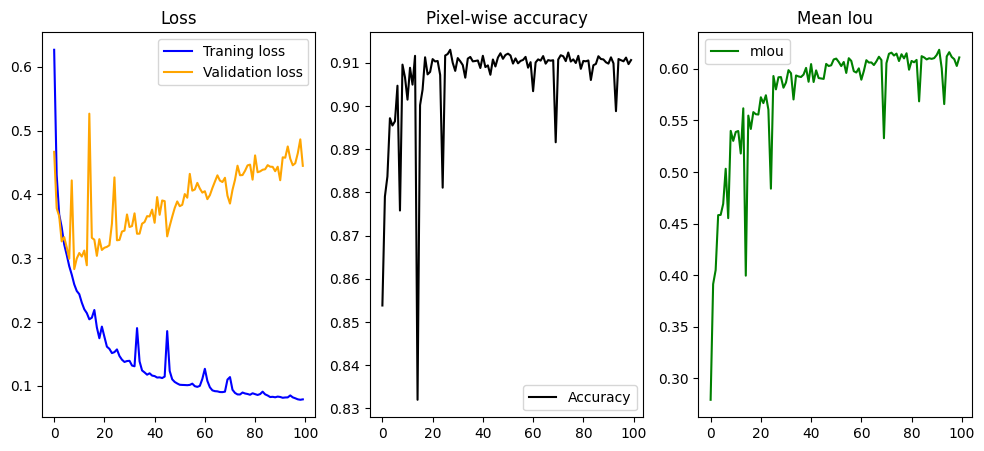

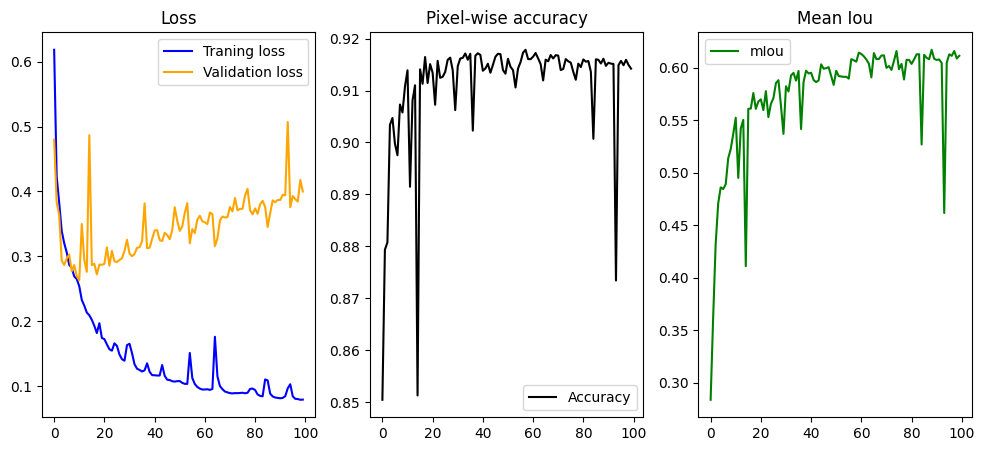

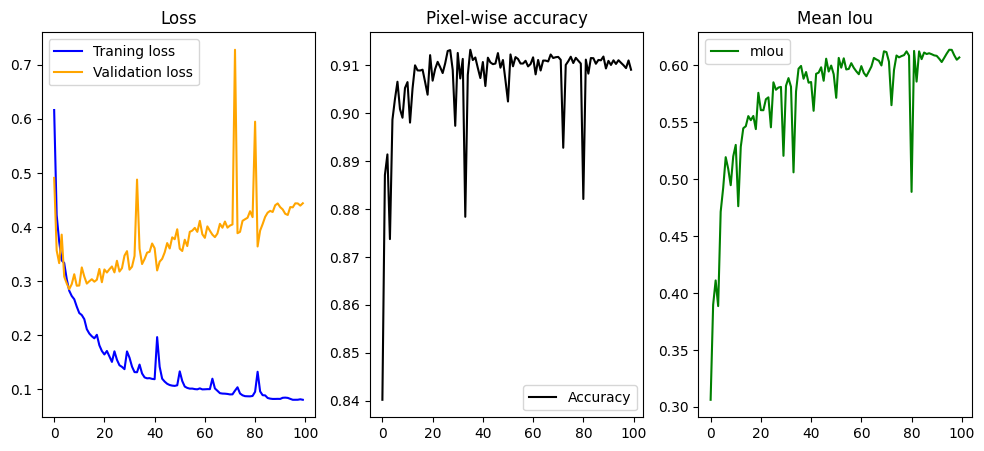

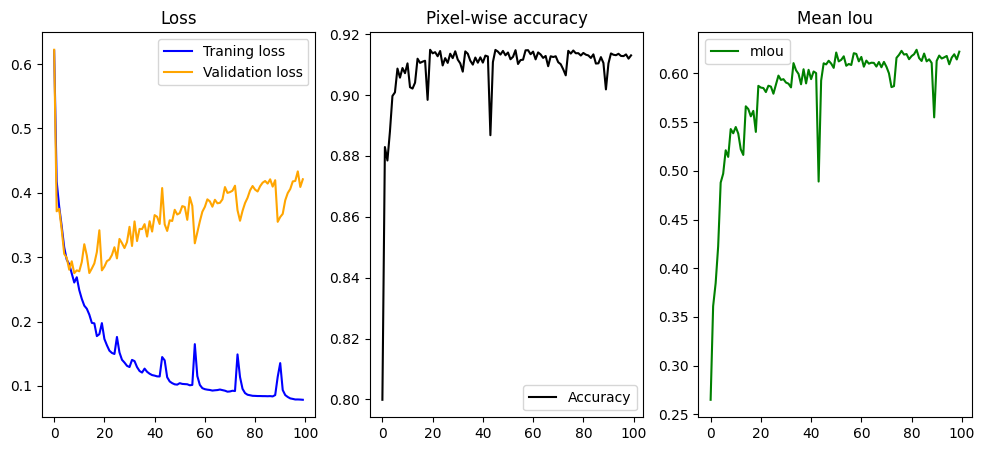

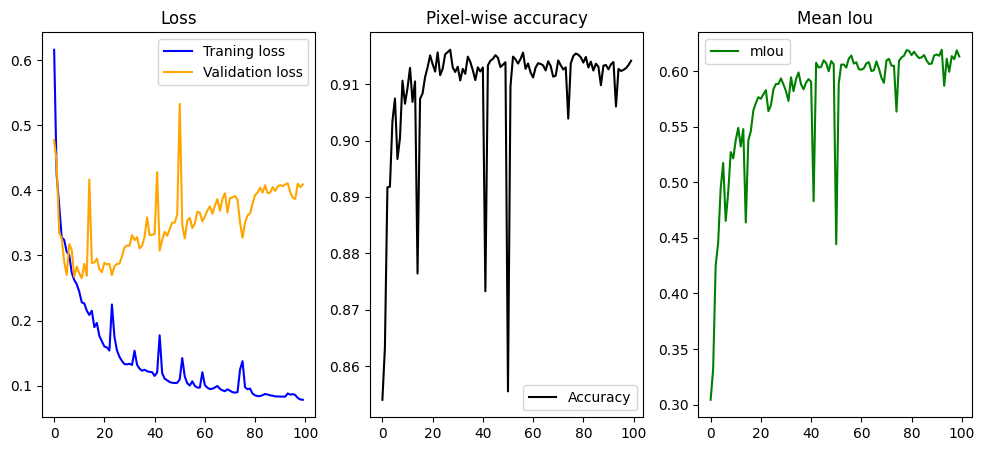

In [54]:
# Show results of training
training_loss=np.genfromtxt((Path(workspace_path)/model_folder_name/"training_loss.csv").as_posix(),dtype=None,encoding='utf-8',delimiter=',')
val_loss=np.genfromtxt((Path(workspace_path)/model_folder_name/"val_loss.csv").as_posix(),dtype=None,encoding='utf-8',delimiter=',')
val_pixel_wise_accuracy=np.genfromtxt((Path(workspace_path)/model_folder_name/"val_pixel_wise_accuracy.csv").as_posix(),dtype=None,encoding='utf-8',delimiter=',')
val_mIoU=np.genfromtxt((Path(workspace_path)/model_folder_name/"val_mIoU.csv").as_posix(),dtype=None,encoding='utf-8',delimiter=',')

for epoch_index in range(num_folds):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(training_loss[epoch_index], color='blue', label='Traning loss')
    plt.plot(val_loss[epoch_index], color='orange', label='Validation loss')
    plt.title("Loss")
    plt.legend(loc='best')
    plt.subplot(1, 3, 2)
    plt.plot(val_pixel_wise_accuracy[epoch_index], color='black', label='Accuracy')
    plt.legend(loc='best')
    plt.title("Pixel-wise accuracy")
    plt.subplot(1, 3, 3)
    plt.plot(val_mIoU[epoch_index], color='green', label='mIou')
    plt.legend(loc='best')
    plt.title("Mean Iou")
    plt.show()

In [14]:
# Testing parameters
model_file_name="model_params_1_15.pth"

In [8]:
# Load testing data
testing_dataset=CustomDataset(workspace_path,"test_data_path.csv",color_transforms,target_size,loading_mode)
testing_loader=DataLoader(testing_dataset,batch_size,shuffle=False,drop_last=True)

Load images and labels: 100%|██████████| 1492/1492 [00:01<00:00, 774.48it/s]


In [15]:
# Testing
torch.cuda.empty_cache()
model=BiseNet.BiSeNet(num_classes)
model.load_state_dict(torch.load((Path(workspace_path)/model_folder_name/model_file_name)))
model.to(device)
model.eval()

correct_pixel_sum=0
pixel_sum=0
total_intersection=np.zeros(num_classes,dtype=np.int64)
total_union=np.zeros(num_classes,dtype=np.int64)
with torch.no_grad():
    for images, labels in tqdm(testing_loader, desc="testing: ", leave=False):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        pred_labels = torch.argmax(probs, dim=1)
        correct_pixel_sum+=(pred_labels==labels).sum().item()
        pixel_sum+=labels.numel()
        for pred, label in zip(pred_labels, labels):
            for index in range(num_classes):
                pred_inds = (pred == index)
                label_inds = (label == index)
                intersection = (pred_inds & label_inds).sum().item()
                union = (pred_inds | label_inds).sum().item()
                total_intersection[index] += intersection
                total_union[index] += union
pixel_accuracy=correct_pixel_sum/pixel_sum
iou=total_intersection[1:]/(total_union+1e-6)[1:]
mIoU=iou.mean().item()
print(f"pixel-wise accuracy: {pixel_accuracy:.4f} mIoU: {mIoU:.4f}")

/tmp/ipykernel_499838/3217116959.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load((Path(workspace_path)/model_folder_name/model_file_name

pixel-wise accuracy: 0.9081 mIoU: 0.5433
